# Team 2: Machine Learning Model Development & Evaluation Notebook 

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold

import sqlalchemy as sqla
import pymysql
from sqlalchemy import create_engine

import csv
import datetime as dt

In [2]:
URI='database-comp30830.c2kwpm1jk01q.us-east-1.rds.amazonaws.com'
PORT='3306'
DB='comp30830_db'
PASSWORD='Simple12'
USER='admin'

In [3]:
engine = create_engine("mysql+mysqldb://{}:{}@{}:{}/{}".format(USER, PASSWORD,
                                                              URI, PORT, DB), echo=True)

In [4]:
bikes=pd.read_sql_table('live_bike_data', engine)  

2020-04-12 14:11:58,850 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2020-04-12 14:11:58,853 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:11:58,969 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2020-04-12 14:11:58,970 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:11:59,201 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2020-04-12 14:11:59,203 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:11:59,430 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2020-04-12 14:11:59,432 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:11:59,549 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2020-04-12 14:11:59,550 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:11:59,665 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2020-04-12 14:11:59,667 INFO sqlalchemy.engine.base.E

In [5]:
# Make a new dataframe of this table
bikes.to_csv('allBikes.csv', index=False)

In [6]:
# Read csv file into a dataframe.
bikes = pd.read_csv('allBikes.csv')

In [7]:
weather=pd.read_sql_table('live_weather_data', engine)  

2020-04-12 14:13:14,685 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-04-12 14:13:14,686 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:13:15,788 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-04-12 14:13:15,790 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:13:16,697 INFO sqlalchemy.engine.base.Engine SHOW CREATE TABLE `live_weather_data`
2020-04-12 14:13:16,699 INFO sqlalchemy.engine.base.Engine ()
2020-04-12 14:13:26,972 INFO sqlalchemy.engine.base.Engine SELECT live_weather_data.number, live_weather_data.main, live_weather_data.description, live_weather_data.icon, live_weather_data.temp, live_weather_data.`tempMin`, live_weather_data.`tempMax`, live_weather_data.`tempFeels`, live_weather_data.humidity, live_weather_data.pressure, live_weather_data.`windSpeed`, live_weather_data.`windDeg`, live_weather_data.rain, live_weather_data.sunrise, live_weather_data.sunset, live_weather_data.date, live_weather_data.time, 

In [8]:
# Make a new dataframe of this table
weather.to_csv('allWeather.csv', index=False)

In [9]:
# Read csv file into a dataframe.
weather = pd.read_csv('allWeather.csv')

In [10]:
bikes['datetime'] = pd.to_datetime(bikes['date'] + ' ' + bikes['time'])
weather['datetime'] = pd.to_datetime(weather['date'] + ' ' + weather['time'])

In [11]:
bikes = bikes.sort_values(by='datetime')
weather = weather.sort_values(by='datetime')

## This can be used as a checkpoint, start from here if you want to run again without having to call from the database.

In [12]:
full_df = pd.merge_asof(bikes, weather, left_on="datetime", right_on="datetime",direction="nearest")

In [13]:
full_df.head(3)

,ID,availableBikeStands,availableBikes,date_x,time_x,day_x,status,epoch,datetime,number,...,humidity,pressure,windSpeed,windDeg,rain,sunrise,sunset,date_y,time_y,day_y
0,84,6,24,2020-02-18,19:54:59,Tue,OPEN,NaN,2020-02-18 19:54:59,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
1,67,21,19,2020-02-18,19:55:27,Tue,OPEN,NaN,2020-02-18 19:55:27,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
2,8,30,0,2020-02-18,19:55:35,Tue,OPEN,NaN,2020-02-18 19:55:35,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue


In [14]:
# constrict the dataframe to only those times in which the service is available to users.
full_df = full_df.drop(full_df[(full_df.datetime.dt.hour > 0) & (full_df.datetime.dt.hour < 5)].index)

- Here we will develop the features upon which the model will be trained. The features chosen will primarily be derived from our weather database as it is the team's belief that will be direct correlation between bike avaiability and weather conditions.

In [15]:
## Create four flags each representing the stage of the day.
morning_start = pd.to_datetime("05:00:00").time()
morning_end = pd.to_datetime("12:00:00").time()
afternoon_start = pd.to_datetime("12:01:00").time()
afternoon_end = pd.to_datetime("16:59:00").time()
evening_start = pd.to_datetime("17:00:00").time()
evening_end = pd.to_datetime("20:00:00").time()
night_start = pd.to_datetime("20:01:00").time()
night_end = pd.to_datetime("23:59:59").time()

In [16]:
full_df['morning'] = np.where((full_df['datetime'].dt.time > morning_start)
                         & (full_df['datetime'].dt.time < morning_end),
                         1, 0)

full_df['afternoon'] = np.where((full_df['datetime'].dt.time > afternoon_start)
                         & (full_df['datetime'].dt.time < afternoon_end),
                         1, 0)

full_df['evening'] = np.where((full_df['datetime'].dt.time > evening_start)
                         & (full_df['datetime'].dt.time < evening_end),
                         1, 0)

full_df['night'] = np.where((full_df['datetime'].dt.time > night_start)
                         & (full_df['datetime'].dt.time < night_end),
                         1, 0)

In [17]:
#replace days with numbers
full_df["day_x"].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], [0,1,2,3,4,5,6], inplace=True)

In [18]:
# create a time of day column, based on the hours of the day.
full_df['tod'] = full_df.datetime.dt.hour

- Observe the usage on a given weekday at a particular station:

In [19]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 2)]

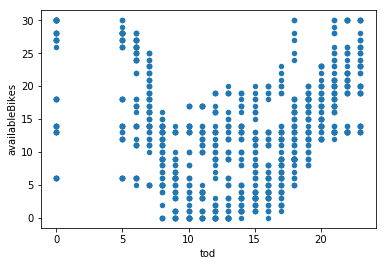

In [20]:
# First, plot the observed data
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

In [21]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 4)]

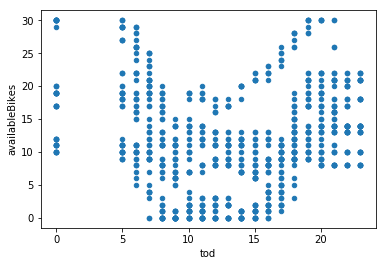

In [22]:
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

- Observe the usage on a given weekend day at the same station:

In [23]:
weekend_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 5)]

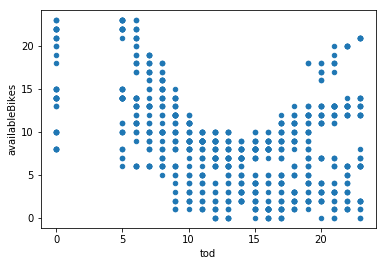

In [24]:
# First, plot the observed data
weekend_test_df.plot(kind='scatter', x='tod', y='availableBikes')

- From each of these plots, we can observe a variance between usage during the week and during the weekend. Weekdays generally see heavier usage during the morning time, while weekends see more usage during the afternoon/evening time. Therefore, two spearate models will be developed- one for Monday to Friday and another for Saturdays and Sundays.

In [25]:
#clouds
full_df["number"].replace([801,802,803,804], 'clouds', inplace=True)

#clear
full_df["number"].replace([800], 'clear', inplace=True)

#Atmosphere
full_df["number"].replace([701,711,721,731,741,751,761,762,771,781], 'Atmosphere', inplace=True)

#snow
full_df["number"].replace([600,601,602,611,612,613,615,616,620,621,622], 'snow', inplace=True)

#rain
full_df["number"].replace([500,501,502,503,504,511,520,521,522,531], 'rainfall', inplace=True)

#drizzle
full_df["number"].replace([300,301,302,310,311,312,313,314,321], 'drizzle', inplace=True)

#thunderstorm
full_df["number"].replace([200,201,202,210,211,212,221,230,231,232], 'thunderstorm', inplace=True)

In [26]:
full_df.drop(["date_x","time_x","status", "epoch", "main",
         "description","icon", "tempMin", "tempMax", "tempFeels", "humidity",
         "pressure", "windSpeed","windDeg","sunrise", "sunset",
             "date_y","time_y", "day_y"],axis=1,inplace=True)

In [27]:
# add a flag that indicates whether a day is dry (has zero rain)
full_df['dry_day'] = (full_df['rain'] == 0).astype(int)

In [28]:
full_df = full_df.rename(columns={"availableBikes": "target"})
full_df.drop(["availableBikeStands"], axis=1,inplace=True)

In [29]:
week_df = full_df.loc[(full_df['day_x'] >= 0) & (full_df['day_x'] <= 4)]

In [30]:
weekend_df = full_df.loc[(full_df['day_x'] >= 5) & (full_df['day_x'] <= 6)]

- Seperate models will be generated for weekly data and weekend data.

In [31]:
station = int(input("Please enter station ID: "))
week_or_weekend = int(input("Please choose to predict for week - (0) or weekend - (1): "))
# bikes_or_stands = int(input("Please choose to predict either availableBikeStands(0) or availableBikes(1): "))
# Constrain df to a single station on a single day
if week_or_weekend == 0:
    new_df = week_df.loc[(week_df.ID == station)]
else:
    new_df = weekend_df.loc[(weekend_df.ID == station)]

# Constrain df to a single station on a single day
# new_df = full_df.loc[(full_df['ID'] == station) & (full_df['day_x'] == day)]

Please enter station ID: 42
Please choose to predict for week - (0) or weekend - (1): 0


In [32]:
## Dropping all columns not necessary for predictive model.
new_df.drop(["ID", "datetime"], axis=1,inplace=True)

/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
# Make a new dataframe of this station
new_df.to_csv('comp303830_model_multipleLinearRegression.csv', index=False)

In [34]:
# Read csv file into a dataframe.
df = pd.read_csv('comp303830_model_multipleLinearRegression.csv')

In [35]:
df.head(3)

,target,day_x,number,temp,rain,morning,afternoon,evening,night,tod,dry_day
0,28,1,clouds,2.0,0.0,0,0,0,1,20,1
1,29,1,clouds,2.0,0.0,0,0,0,1,20,1
2,30,1,clouds,2.0,0.0,0,0,0,1,20,1


In [36]:
# Print the average target(availableBikes) in our dataset.
# We could use this as a very simple baseline prediction model.
# A better prediction model should at least improve on this baseline model.
round(df.target.mean())

17.0

### Observing the data:
- Trying to find correlations between continuous data and the target feature:

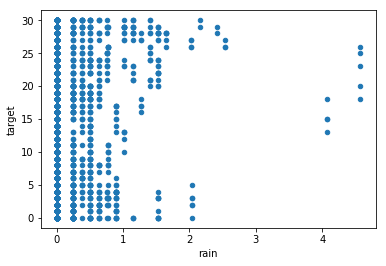

In [37]:
# First, plot the observed data
df.plot(kind='scatter', x='rain', y='target')

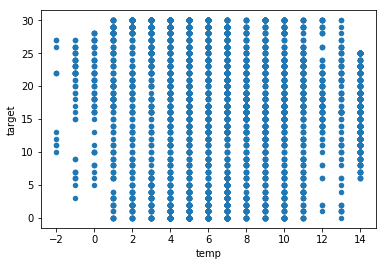

In [38]:
# First, plot the observed data
df.plot(kind='scatter', x='temp', y='target')

- There does not appear to be a clear correlation between the target feature and the continuous data

## Training with continuous and categorical features

In [39]:
#replace days with numbers
df["day_x"].replace([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], inplace=True)

In [40]:
#We can also do this directly for all categorical features
df = pd.get_dummies(df, drop_first=True)

In [41]:
# Input features must exclude the target feature
column_names = list(df.columns)[1:]

In [42]:
X = df[column_names]
y = df.target

In [43]:
# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X['tod'], prefix='tod', drop_first=True)
# Add all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=['tod'], inplace=True)

## Train a model based upon multiple linear regression

In [44]:
# Drop any rows with null values
df.dropna(axis=0, how='any', inplace=True)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
df['deg_1_pred'] = model.predict(X)

In [45]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [46]:
printMetrics(y, model.predict(X))


MAE:  5.7309171791373466
RMSE:  6.7687701965784175
R2:  0.4201595526980956


- These metrics demonstrate that this model will reliably predict availability to within ~5-7 bikes.

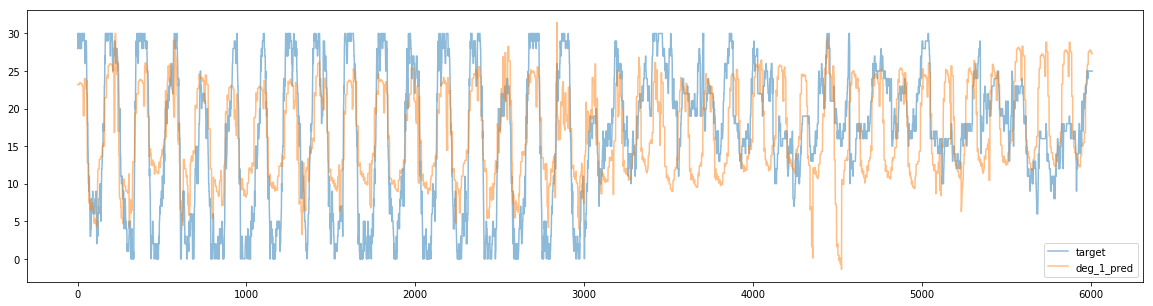

In [47]:
df[['target', 'deg_1_pred']].plot(alpha=0.5, figsize=(20, 5))

- This graph shows us that the model is accurate at predicting bike availability about half of the time.

<ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html >

## Use k-folds cross-validation (k=3) to assess the performance of our model:

In [48]:
X_column_name = list(X.columns)
X_one_deg = pd.DataFrame(X[X_column_name])
y = pd.DataFrame(df.target)
model = LinearRegression()
scores = []
print("Coefficient of Determination (R2):")
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X_one_deg, y)):
    model.fit(X_one_deg.iloc[train,:], y.iloc[train,:])
    score = model.score(X_one_deg.iloc[test,:], y.iloc[test,:])
    scores.append(score)
    print(scores)

Coefficient of Determination (R2):
[0.4730956488687701]
[0.4730956488687701, 0.44093585333665286]
[0.4730956488687701, 0.44093585333665286, 0.45216549547778373]


- This evaluation demonstrates that the performance of our model is robust and reliable in not veering from the r^2 value too much on different evaluations.

<ref: https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5 >

## Having already observed a nonlinear relationship between bike availability and the time of the day, we will now investigate whether our linear model would more effectively predict our target value if implemented polynomially.

In [49]:
## Using scikit's built-in Polynomial Features
polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

In [50]:
model = LinearRegression()
model.fit(X_poly, y)
y_poly_pred = model.predict(X_poly)
df['deg_2_pred'] = y_poly_pred

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("Root Mean Square Error: ", rmse)
print("Coefficient of Determination (R2): ", r2)

Root Mean Square Error:  5.434506959518114
Coefficient of Determination (R2):  0.6262258473867637


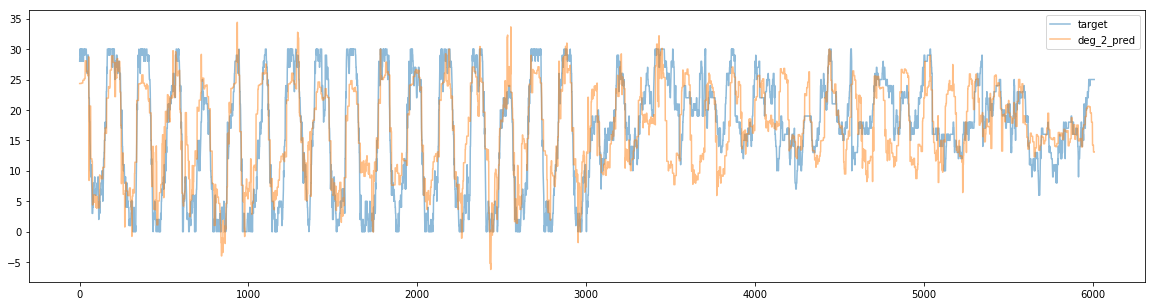

In [51]:
df[['target', 'deg_2_pred']].plot(alpha=0.5, figsize=(20, 5))

- The graph above displays that the model trained on polynomial data performs better than the model trained on single-dimensional data. The r^2 value is also marginally improved in comparison to the single dimensional based model.

# Train/Testing evaluation will be carried out on each model.

## Evaluation with train/test split - single dimensional & polynomial based models.

In [52]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
X_train_one_d, X_test_one_d, y_train_one_d, y_test_one_d = train_test_split(X, y, test_size=0.3)
X_train_polynomial, X_test_polynomial, y_train_polynomial, y_test_polynomial = train_test_split(X_poly, y, test_size=0.3)

In [53]:
# Train on the training sample and test on the test sample.
one_d_multi_linreg = LinearRegression().fit(X_train_one_d, y_train_one_d)
polynomial_multi_linreg = LinearRegression().fit(X_train_polynomial, y_train_polynomial)

In [54]:
# Predicted avaialbleBikes on training set
one_d_train_predictions = one_d_multi_linreg.predict(X_train_one_d)
polynomial_train_predictions = polynomial_multi_linreg.predict(X_train_polynomial)
print("Training metrics for single dimensional model:")
printMetrics(y_train_one_d, one_d_train_predictions)
print(" ")
print("Training metrics for polynomial model:")
printMetrics(y_train_polynomial, polynomial_train_predictions)

Training metrics for single dimensional model:

MAE:  5.56771630144568
RMSE:  6.52240062865685
R2:  0.4632851771868943
 
Training metrics for polynomial model:

MAE:  4.255461318775682
RMSE:  5.421728688562956
R2:  0.636325273751549


- The training metrics for the polynomial model are marinally better than the single-dimensional model.

In [55]:
# Predicted avaialbleBikes on test set
one_d_test_predictions = one_d_multi_linreg.predict(X_test_one_d)
polynomial_test_predictions = polynomial_multi_linreg.predict(X_test_polynomial)

print("Testing metrics for single dimensional model:")
printMetrics(y_test_one_d, one_d_test_predictions)
print(" ")
print("Testing metrics for polynomial model:")
printMetrics(y_test_polynomial, polynomial_test_predictions)

Testing metrics for single dimensional model:

MAE:  5.514561502052939
RMSE:  6.461360802187523
R2:  0.4677317125807069
 
Testing metrics for polynomial model:

MAE:  1524122.7639272474
RMSE:  62177849.254198335
R2:  -51698666058477.46


- The polynomial model, when introduced to unseen data, performs extremely poorly. This is likely due to overfitting. For this reason we will discard the polynomial model. The single-dimensional model, on the other hand, demonstrates reliability in its results between the training set and the testing set.

## Evaluation with cross-validation - single dimensional based model.

In [56]:
one_d_scores = -cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=5)
one_d_scores

array([6.84315117, 6.41840951, 6.32762216, 7.06657599, 6.36014255])

In [57]:
one_d_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
one_d_scores = cross_validate(LinearRegression(), X, y, scoring=one_d_metrics, cv=5)
print("Metrics on cross validated one dimensional based model:")
one_d_scores

Metrics on cross validated one dimensional based model:


/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)

{'fit_time': array([0.00513506, 0.00395894, 0.00507498, 0.00386691, 0.00373411]),
 'score_time': array([0.00313902, 0.0026598 , 0.00379109, 0.00254798, 0.00256205]),
 'test_neg_mean_absolute_error': array([-6.84315117, -6.41840951, -6.32762216, -7.06657599, -6.36014255]),
 'train_neg_mean_absolute_error': array([-5.31053089, -5.42823346, -5.40451772, -5.24317148, -5.44985136]),
 'test_neg_mean_squared_error': array([-59.76482255, -52.66027681, -55.25146307, -68.76702188,
        -60.46367372]),
 'train_neg_mean_squared_error': array([-40.80417341, -41.60447594, -40.04874854, -38.38791823,
        -41.8181526 ]),
 'test_r2': array([ 0.48189238,  0.57416238,  0.38771597, -1.86819913, -1.74325165]),
 'train_r2': array([0.39094807, 0.38495041, 0.4743259 , 0.57513469, 0.54868652])}

- Once again, evaluation of this model demonstrates that it's performance is robust and reliable. The evaluation metrics seen above do not show much variance between the different training sets offered to it by the cross-validation process. This model will now be deployed as a Python script on our EC2 instance to be run once every 24 hours during the Dublin Bikes system offline time.